In [1]:
import numpy as np
import random
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import matplotlib.pyplot as plt
""" Four rooms. The goal is either in the 3rd room, or in a hallway adjacent to it
"""
import seaborn as sbn
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

NUM_ROOMS = 4


# Environment

In [3]:
class FourRooms(gym.Env):
    metadata = {'render.modes': ['human']}
    def __init__(self,ss,goal_state):
        self.ss = ss
        #Rooms              0       1      2      3
        self.room_sizes = [[5,5], [6,5], [4,5], [5,5]]
        self.pre_hallways = [ 
            { tuple([2,4]) : [RIGHT, 0], tuple([4,1]) : [DOWN, 3]}, #1 origin Up-left (down x)
            { tuple([2,0]) : [LEFT, 0], tuple([5,2]) : [DOWN, 1]},  #2     same
            { tuple([0,2]) : [UP, 1], tuple([2,0]) : [LEFT, 2]},    #3     same
            { tuple([3,4]) : [RIGHT, 2], tuple([0,1]) : [UP, 3]},   #4     same
        ]
        #Rooms                    0       1      2      3
        self.hallway_coords = [ [2,5], [6,2], [2,-1], [-1,1] ] 
        #No chance of being cordinates in any of the rooms
        self.hallways = [ 
            #self.hallways[i][j] = [next_room, next_coord] when taking action j from hallway i#
            [ [0, self.hallway_coords[0]], [1, [2,0]], [0, self.hallway_coords[0]], [0, [2,4]] ],
            [ [1, [5,2]], [1, self.hallway_coords[1]], [2, [0,2]], [1, self.hallway_coords[1]] ],
            [ [2, self.hallway_coords[2]], [2, [2,0]], [2, self.hallway_coords[2]], [3, [3,4]] ],
            [ [0, [4,1]], [3, self.hallway_coords[3]], [3, [0,1]], [3, self.hallway_coords[3]] ]
        ]
        self.offsets = [0] * (NUM_ROOMS + 1)
        for i in range(NUM_ROOMS):
            self.offsets[i + 1] = self.offsets[i] + self.room_sizes[i][0] * self.room_sizes[i][1] + 1
#         print(self.offsets)
        
        self.n_states = self.offsets[4] + 1
        self.absorbing_state = self.n_states
        
        self.goal = goal_state  #G1
        self.terminal_state = self.encode(self.goal)
    
        self.noise = 0.33
        self.step_reward = 0.0
        self.terminal_reward = 1.0
        self.bump_reward = 0
        # start state random location in start room
        
        start_room = 0
        sz = self.room_sizes[start_room]
        self.start_state = self.offsets[start_room] + np.random.randint(sz[0]*sz[1] - 1)
        self.start_state = self._reset
        #doubt can it be initialized in a hallway (NO)
        self._reset()
        
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Discrete(self.n_states) # with absorbing state
    def isT(self,state):
        return state==self.terminal_state
    def ind2coord(self, index, sizes):
#         sizes = [self.n]*2
        [rows, cols] = sizes
        assert(index >= 0)
        row = index // cols
        col = index % cols
        return [row, col]

    def coord2ind(self, coord, sizes):
        [rows, cols] = sizes
        [row, col] = coord
        assert(row < rows)
        assert(col < cols)
        return row * cols + col
    def in_hallway_index(self, index=None):
        if index is None:
            index = self.state
        return index in [offset - 1 for offset in self.offsets]

    def in_hallway_coord(self, coord):
        return coord in self.hallway_coords

    def encode(self, location, in_hallway=None):
        [room, coord] = location
        if in_hallway is None:
            in_hallway = self.in_hallway_coord(coord)
        if in_hallway:
            return self.offsets[room + 1] - 1
        # maybe have hallways as input
        ind_in_room = self.coord2ind(coord, sizes=self.room_sizes[room])
        return ind_in_room + self.offsets[room]

    def decode(self, index, in_hallway=None):
        if in_hallway is None:
            in_hallway = self.in_hallway_index(index=index)
        room = [r for r, offset in enumerate(self.offsets[1:5]) if index < offset][0]
        if in_hallway:
            coord_in_room = self.hallway_coords[room]
        else:
            coord_in_room = self.ind2coord(index - self.offsets[room], sizes=self.room_sizes[room])
        return room, coord_in_room # hallway
    
    def _step(self, action,block):
        assert self.action_space.contains(action)
        preaction = action
        in_hallway = self.in_hallway_index()
        [room, coord]= self.decode(self.state, in_hallway=in_hallway)
#         print(room,coord)
        room2 = room; coord2 = coord
        if np.random.rand() < self.noise:
#             print("noice")
            a = action
            while a==action:
                a = self.action_space.sample()
            action = a
            
        if block:
            ###No USE
            action = preaction
#         print(action)
        if in_hallway: # hallway action
#             print("hallway")
            [room2, coord2] = self.hallways[room][action]
        elif tuple(coord) in self.pre_hallways[room].keys():
#             print("hey")
            hallway_info = self.pre_hallways[room][tuple(coord)]
            if action == hallway_info[0]:
                room2 = hallway_info[1]
                coord2 = self.hallway_coords[room2]
            else:
                [row, col] = coord
                [rows, cols] = self.room_sizes[room]
                if action == UP:
                    row = max(row - 1, 0)
                elif action == DOWN:
                    row = min(row + 1, rows - 1)
                elif action == RIGHT:
                    col = min(col + 1, cols - 1)
                elif action == LEFT:
                    col = max(col - 1, 0)
                room2 = room
                coord2 = [row, col]
        else: # normal action
            [row, col] = coord
            [rows, cols] = self.room_sizes[room]
            if action == UP:
                row = max(row - 1, 0)
            elif action == DOWN:
                row = min(row + 1, rows - 1)
            elif action == RIGHT:
                col = min(col + 1, cols - 1)
            elif action == LEFT:
                col = max(col - 1, 0)
            coord2 = [row, col]
#         print("new room new cord" ,room2,coord2)
        new_state = self.encode([room2, coord2])
        self.state = new_state
        reward = self._get_reward(new_state=new_state)
        if self.state == self.terminal_state:
            self.done = True
            return self.state, self._get_reward(), self.done, None

        return new_state, reward, self.done, None

    def _get_reward(self, new_state=None):
        if self.done:
            return self.terminal_reward
        reward = self.step_reward
        if self.bump_reward != 0 and self.state == new_state:
            reward = self.bump_reward
        return reward

    def at_border(self):
        [row, col] = self.ind2coord(self.state)
        return (row == 0 or row == self.n - 1 or col == 0 or col == self.n - 1)

    def _reset(self):
        self.done = True
        while self.done:
            start_room = 0
            sz = self.room_sizes[start_room]
            self.start_state = self.offsets[start_room] + np.random.randint(sz[0]*sz[1] - 1)
            self.state = self.start_state
            self.done = (self.state==self.terminal_state)
#         self.state = self.encode([3,[2,2]])
        if self.ss != [0,[0,0]]:
            self.state = self.encode(self.ss)
        return self.state
#         return self.encode([3,[2,2]])

    def _render(self, mode='human', close=False):
        pass

# Option Trajectory

In [63]:

hwpos = {
        #division of options based on the hallway pos in the specified room say 4 itself[i][0] 5 other[i][1]
        0 : [3,0],
        1 : [0,1],
        2 : [1,2],
        3 : [2,3],
    }
xy_actions = {    #increase x     decrease x    increase y    decrease y
     0 : [2,0,1,3],
     1 : [2,0,1,3],
        2 :[2,0,1,3],
        3 :[2,0,1,3],
}
# hw_ind
def option_trajec(state,opt,env):
    [room,coord]=env.decode(state)
    tg_hw = hwpos[room][opt]
    pre_hw = env.pre_hallways[room].keys()
    tprehw_coord = [0,0]
    for p in pre_hw:
        if(tg_hw==env.pre_hallways[room][p][1]):
            tprehw_coord =list(p)
    
    thw_coord = env.hallway_coords[tg_hw]
#     print("Option towards ",room,tprehw_coord);
    nthw_coord = env.hallway_coords[hwpos[room][1-opt]]
    curr_coord = coord
    Trajec = []
    our_room = room
#     print(room)
#     print(state)
    n_st = state
    while(curr_coord != thw_coord):
        action_sel = -1
        
        rc = np.array(tprehw_coord)-np.array(curr_coord)
        ###########Action Selecting#########
        if(abs(rc[0])>abs(rc[1])):
            if(rc[0]>0):
                action_sel =  2
            else:
                action_sel = 0
        elif(abs(rc[0])<abs(rc[1])):
            if(rc[1]>0):
                action_sel = 1
            else:
                action_sel = 3
        else:
            i = random.randint(0,1)
            if(i==0):
                if(rc[0]>0):
                    action_sel =  2
                else:
                    action_sel = 0
            else:
                if(rc[1]>0):
                    action_sel = 1
                else:
                    action_sel = 3 
        if(curr_coord==nthw_coord):
            tup=[]
            tup.append(env.encode([room,curr_coord]))
            tup.append(0)
            tup.append(0)
            Trajec.append(tup)
            return Trajec
        else:
            if(rc[0]==0 and rc[1]==0):
                action_sel = env.pre_hallways[room][tuple(tprehw_coord)][0]
        tup = []
        tup.append(env.encode([room,curr_coord]))
        tup.append(action_sel)
#         print(e.state)
        n_st,r,term,_=env._step(action_sel,False)
        tup.append(r)
        Trajec.append(tup)
#         print(env.decode(n_st))
        [room,curr_coord] = env.decode(n_st)
        if term:
            break
    tup=[]
    tup.append(n_st)
    tup.append(0)
    tup.append(0)
    Trajec.append(tup)
    return Trajec


In [64]:
#OPTIONTRAJEC 2 was waste of time because beta[s] for states which are hallways and states outside the room is 1
#So stop if option goes out of room ie in target hallway or non target hallway

In [68]:
def get_action(a,eps):
    if np.random.binomial(1, eps) == 1:
        return np.random.randint(0,6) # +2 for options
    mx = np.max(a)
    idx = np.where(a == mx)[0]
    return np.random.choice(idx)
def get_best_action(a):
    mx = np.max(a)
    idx = np.where(a == mx)[0]
    return np.random.choice(idx)

# SMDP Run

In [4]:
from collections import defaultdict
def smdp_q_learning(env,num_episodes,gamma = 0.9 , alpha = 0.25, epsilon = 0.1):
    Q = defaultdict(lambda:np.zeros(6))
#     env.reset()
#     env.render()
    Episodelen = []
    AvgReward = []
    for episode in range(num_episodes):
#         env.render()
#         print("Episode ",episode)
        resetedpos = env._reset()
#         print("Start state ",resetedpos)
        state = resetedpos
        rew = 0
        length = 0
        while(1):
#             print("State is ",env.decode(env.state))
            length+=1
            Action_sel = get_action(Q[state],epsilon)     
            if(Action_sel<=3):
                ######Primitive Actions########
                next_state, reward,isT, _ = env._step(Action_sel,False)
#                 print("State is",next_state)
                rew+=reward
                length+=1
#                 print("#primitive ",Action_sel)
                best_n_action = get_best_action(Q[next_state])
                #UPDATING
                d = reward + (gamma * Q[next_state][best_n_action]) - Q[state][Action_sel]
                Q[state][Action_sel] = Q[state][Action_sel]+alpha * (d)
                if isT:
                    break
                state = next_state
            else:
                ###options#####
                ###USE OPTION TRAJECTORY######
#                 print("before",env.state)
                Trajec = option_trajec(state,Action_sel-4,env)
                Return_opt = 0
                gamma_pow = 1
                for i in range(len(Trajec)):
                    Return_opt = Trajec[len(Trajec)-1-i][2] + gamma * Return_opt
                    gamma_pow = gamma_pow * gamma
                rew+=Return_opt
                length+=len(Trajec)
                n_st = Trajec[len(Trajec)-1][0]
                #Only for options
                best_n_action = get_best_action(Q[n_st])
                delt  = Return_opt + (gamma_pow * Q[n_st][best_n_action])-Q[state][Action_sel]
                Q[state][Action_sel] = Q[state][Action_sel] + (alpha * delt)
                if(env.isT(n_st)):
                    break
                state = n_st
        AvgReward.append(rew)
        Episodelen.append(length)
    return AvgReward,Episodelen,Q

In [70]:
ss = [0,[0,0]] # [0,[0,0]],[3,[2,2]]
goal_state =  [1, [6,2]] #[2,[1,2]],[1,[6,2]]
e = FourRooms(ss,goal_state) 
num_episode = 10000
Q_qlearn = defaultdict(lambda:np.zeros(6))
r_qlearn = np.zeros(num_episode)
l_qlearn = np.zeros(num_episode)

num_runs = 30
smooth = 5
for i in range(num_runs):
    print(i)
    
    r,l,q = smdp_q_learning(e,num_episode)
    print("Max is ",np.max(l))
    for j in range(num_episode):
        r_qlearn[j]=(r_qlearn[j]*(i)+r[j])/(i+1)
        l_qlearn[j]=(l_qlearn[j]*(i)+l[j])/(i+1)
    for k in range(e.n_states):
        for a in range(6):
            Q_qlearn[k][a]=(Q_qlearn[k][a]*(i)+q[k][a])/(i+1)
        


0
Max is  539
1
Max is  272
2
Max is  255
3
Max is  247
4
Max is  190
5
Max is  271
6
Max is  677
7
Max is  553
8
Max is  540
9
Max is  259
10
Max is  212
11
Max is  204
12
Max is  335
13
Max is  197
14
Max is  353
15
Max is  438
16
Max is  280
17
Max is  280
18
Max is  219
19
Max is  341
20
Max is  238
21
Max is  238
22
Max is  255
23
Max is  417
24
Max is  214
25
Max is  298
26
Max is  345
27
Max is  510
28
Max is  295
29
Max is  286


In [71]:
# print(r_qlearn)

In [5]:
# print("[")
# for l in l_qlearn:
#     print(l,end = ",")
# print("]")

In [73]:
r_qllearn = np.zeros(num_episode)
for i in range(num_episode):
        r_qllearn[i]=r_qlearn[i]/l_qlearn[i]

In [74]:
# print(Q_qlearn)
offset = {0:[0,0],1:[0,6],3:[6,0],2:[7,6]}
mask = np.array([[False]*11 for i in range(11)])
for i in range(11):
    mask[i][5] = True
for i in range(6):
    mask[5][i] = True
for i in range(6,11):
    mask[6][i] = True
mask[2][5] = False
mask[5][1] = False
mask[6][8] = False
mask[9][5] = False
e = FourRooms(ss,goal_state) 
####MASKING FOR HEATMAPS
Q_qlearn[e.terminal_state]=np.array([1,1,1,1,1,1])

# Plots

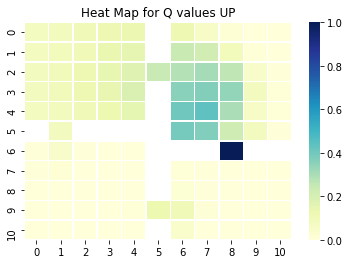

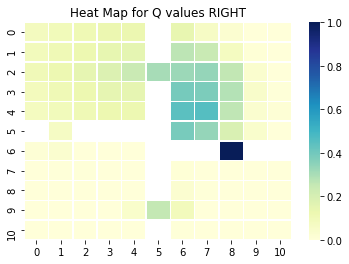

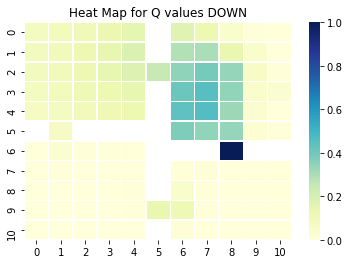

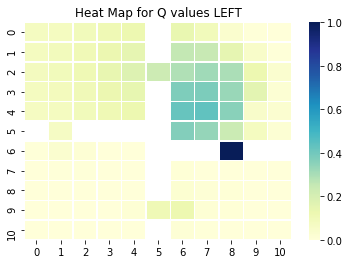

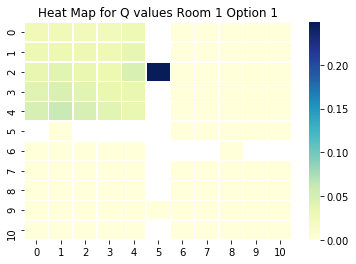

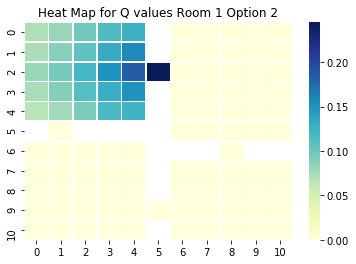

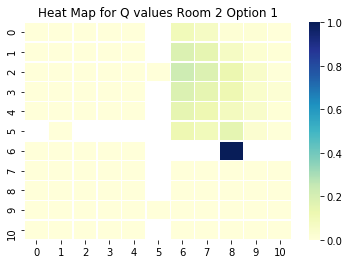

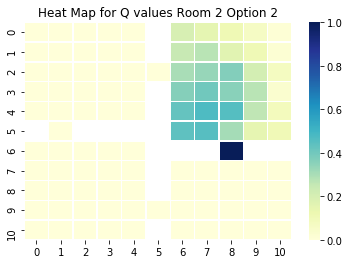

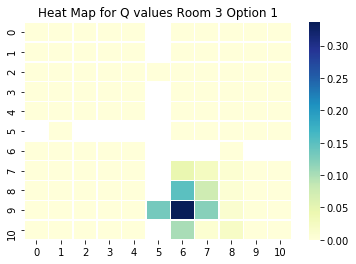

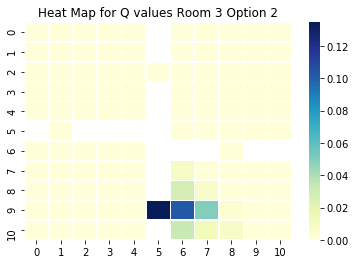

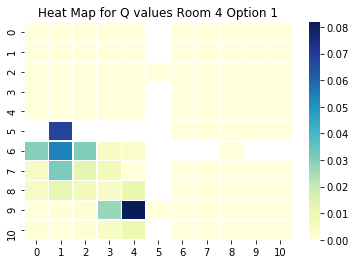

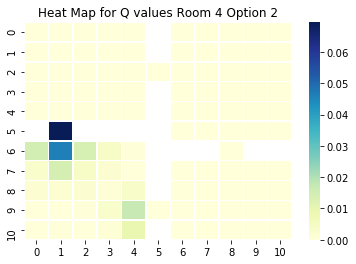

In [75]:
e = FourRooms(ss,goal_state) 

q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            i = c[0]
            j = c[1]
        if r==1:
            i = c[0]
            j = c[1]+6
        if r==2:
            i = c[0]+7
            j = c[1]+6
        if r==3:
            i = c[0]+6
            j = c[1]
        q[i][j] = Q_qlearn[k][0]
        
# %matplotlib inline  
# %matplotlib notebook
# %pylab
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values UP")
plt.show()
e = FourRooms(ss,goal_state) 

q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            i = c[0]
            j = c[1]
        if r==1:
            i = c[0]
            j = c[1]+6
        if r==2:
            i = c[0]+7
            j = c[1]+6
        if r==3:
            i = c[0]+6
            j = c[1]
        q[i][j] = Q_qlearn[k][1]
        
# %matplotlib inline  
# %matplotlib notebook
# %pylab
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values RIGHT")
plt.show()
e = FourRooms(ss,goal_state) 

q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            i = c[0]
            j = c[1]
        if r==1:
            i = c[0]
            j = c[1]+6
        if r==2:
            i = c[0]+7
            j = c[1]+6
        if r==3:
            i = c[0]+6
            j = c[1]
        q[i][j] = Q_qlearn[k][2]
        
# %matplotlib inline  
# %matplotlib notebook
# %pylab
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values DOWN")
plt.show()
e = FourRooms(ss,goal_state) 

q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            i = c[0]
            j = c[1]
        if r==1:
            i = c[0]
            j = c[1]+6
        if r==2:
            i = c[0]+7
            j = c[1]+6
        if r==3:
            i = c[0]+6
            j = c[1]
        q[i][j] = Q_qlearn[k][3]
        
# %matplotlib inline  
# %matplotlib notebook
# %pylab
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values LEFT")
plt.show()
e = FourRooms(ss,goal_state) 

q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            
            i = c[0]
            j = c[1]
            q[i][j] = Q_qlearn[k][4]
        if r==1:
            i = c[0]
            j = c[1]+6
        if r==2:
            i = c[0]+7
            j = c[1]+6
        if r==3:
            i = c[0]+6
            j = c[1]
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values Room 1 Option 1")
plt.show()
e = FourRooms(ss,goal_state) 

q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            
            i = c[0]
            j = c[1]
            q[i][j] = Q_qlearn[k][5]
        if r==1:
            i = c[0]
            j = c[1]+6
        if r==2:
            i = c[0]+7
            j = c[1]+6
        if r==3:
            i = c[0]+6
            j = c[1]
        
# %matplotlib inline  
# %matplotlib notebook
# %pylab
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values Room 1 Option 2")
plt.show()



q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            
            i = c[0]
            j = c[1]
        if r==1:
            
            i = c[0]
            j = c[1]+6
            q[i][j] = Q_qlearn[k][4]
        if r==2:
            i = c[0]+7
            j = c[1]+6
        if r==3:
            i = c[0]+6
            j = c[1]
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values Room 2 Option 1")
plt.show()
e = FourRooms(ss,goal_state) 

q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            
            i = c[0]
            j = c[1]
        if r==1:
            
            i = c[0]
            j = c[1]+6
            q[i][j] = Q_qlearn[k][5]
        if r==2:
            i = c[0]+7
            j = c[1]+6
        if r==3:
            i = c[0]+6
            j = c[1]
        
# %matplotlib inline  
# %matplotlib notebook
# %pylab
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values Room 2 Option 2")
plt.show()






q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            
            i = c[0]
            j = c[1]
        if r==1:
            
            i = c[0]
            j = c[1]+6
        if r==2:
            
            i = c[0]+7
            j = c[1]+6
            q[i][j] = Q_qlearn[k][4]
        if r==3:
            i = c[0]+6
            j = c[1]
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values Room 3 Option 1")
plt.show()
e = FourRooms(ss,goal_state) 

q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            
            i = c[0]
            j = c[1]
        if r==1:
            
            i = c[0]
            j = c[1]+6
        if r==2:
            
            i = c[0]+7
            j = c[1]+6
            q[i][j] = Q_qlearn[k][5]
        if r==3:
            i = c[0]+6
            j = c[1]
        
# %matplotlib inline  
# %matplotlib notebook
# %pylab
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values Room 3 Option 2")
plt.show()





q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            
            i = c[0]
            j = c[1]
        if r==1:
            
            i = c[0]
            j = c[1]+6
        if r==2:
            i = c[0]+7
            j = c[1]+6
        if r==3:
            
            i = c[0]+6
            j = c[1]
            q[i][j] = Q_qlearn[k][4]
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values Room 4 Option 1")
plt.show()
e = FourRooms(ss,goal_state) 

q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            
            i = c[0]
            j = c[1]
        if r==1:
            
            i = c[0]
            j = c[1]+6
        if r==2:
            i = c[0]+7
            j = c[1]+6
        if r==3:
            
            i = c[0]+6
            j = c[1]
            q[i][j] = Q_qlearn[k][5]
        
# %matplotlib inline  
# %matplotlib notebook
# %pylab
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values Room 4 Option 2")
plt.show()


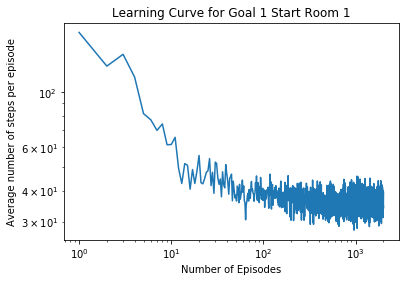

In [82]:
# %matplotlib inline  
# %matplotlib notebook
# %pylab

T = []
# num_episode=500
for i in range(int(num_episode/5)):
    T.append(i+1)
ax = plt.loglog(T,l_qlearn[0:int(num_episode/5)])
plt.xlabel("Number of Episodes")
plt.ylabel("Average number of steps per episode")
plt.title("Learning Curve for Goal 1 Start Room 1")
plt.show()
e = FourRooms(ss,goal_state) 

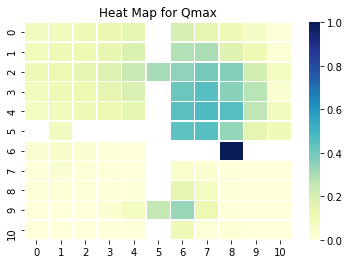

In [78]:
e = FourRooms(ss,goal_state) 

q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            
            i = c[0]
            j = c[1]
        if r==1:
            
            i = c[0]
            j = c[1]+6
        if r==2:
            i = c[0]+7
            j = c[1]+6
        if r==3:
            
            i = c[0]+6
            j = c[1]
        q[i][j] = np.max(Q_qlearn[k])
        
# %matplotlib inline  
# %matplotlib notebook
# %pylab
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Qmax")
plt.show()

In [ ]:

# hwpos = {
#         #division of options based on the hallway pos in the specified room say 4 itself[i][0] 5 other[i][1]
#         0 : [0,3],
#         1 : [1,0],
#         2 : [2,1],
#         3 : [3,2],
#     }
# xy_actions = {    #increase x     decrease x    increase y    decrease y
#      0 : [2,0,1,3],
#      1 : [2,0,1,3],
#         2 :[2,0,1,3],
#         3 :[2,0,1,3],
# }
# # hw_ind


# def option_trajec2(state,opt,env):
#     [room,coord]=env.decode(state)
#     tg_hw = hwpos[room][opt]
#     pre_hw = env.pre_hallways[room].keys()
#     tprehw_coord = [0,0]
#     for p in pre_hw:
#         if(tg_hw==env.pre_hallways[room][p][1]):
#             tprehw_coord =list(p)
    
#     thw_coord = env.hallway_coords[tg_hw]
# #     print("Option towards ",room,tprehw_coord);
# #     edit below to set 
#     nthw_coord = env.hallway_coords[hwpos[room][1-opt]]
#     curr_coord = coord
#     Trajec = []
#     our_room = room
# #     print(room)
# #     print(state)
#     n_st = state
#     while(curr_coord != thw_coord):
#         action_sel = -1
#         block = False
#         if room==our_room:
#             rc = np.array(tprehw_coord)-np.array(curr_coord)
#             ###########Action Selecting#########
#             if(abs(rc[0])>abs(rc[1])):
#                 if(rc[0]>0):
#                     action_sel =  2
#                 else:
#                     action_sel = 0
#             elif(abs(rc[0])<abs(rc[1])):
#                 if(rc[1]>0):
#                     action_sel = 1
#                 else:
#                     action_sel = 3
#             else:
#                 i = random.randint(0,1)
#                 if(i==0):
#                     if(rc[0]>0):
#                         action_sel =  2
#                     else:
#                         action_sel = 0
#                 else:
#                     if(rc[1]>0):
#                         action_sel = 1
#                     else:
#                         action_sel = 3 
#             if(rc[0]==0 and rc[1]==0):
#                 action_sel = env.pre_hallways[room][tuple(tprehw_coord)][0]
#         else:
#             if(curr_coord==nthw_coord):
#                 for i in range(4):
#                     #this is now 
#                     if(env.hallways[room][i][0]==our_room and env.hallways[room][i][1]!=nthw_coord):
#                         action_sel = i
#                         break
#             else:
# #                 print("*****************************************State",room,curr_coord)
                
#                 pre_hwr = env.pre_hallways[room].keys()
#                 ntprehw_coordr = [0,0]
# #                 print(env.pre_hallways[room])
#                 for p in pre_hwr:
# #                     print("Non target ",nthw_coord," hwpos ",hwpos[ env.pre_hallways[room][p][1] ] )
#                     if(nthw_coord == env.hallway_coords[ env.pre_hallways[room][p][1] ] ):
#                         ntprehw_coordr =list(p)
#                         break
# #                 print(ntprehw_coordr)
#                 rc = np.array(ntprehw_coordr)-np.array(curr_coord)
#                 ###########Action Selecting#########
#                 if(abs(rc[0])>abs(rc[1])):
#                     if(rc[0]>0):
#                         action_sel =  2
#                     else:
#                         action_sel = 0
#                 elif(abs(rc[0])<abs(rc[1])):
#                     if(rc[1]>0):
#                         action_sel = 1
#                     else:
#                         action_sel = 3
#                 else:
#                     i = random.randint(0,1)
#                     if(i==0):
#                         if(rc[0]>0):
#                             action_sel =  2
#                         else:
#                             action_sel = 0
#                     else:
#                         if(rc[1]>0):
#                             action_sel = 1
#                         else:
#                             action_sel = 3 
#                 for p in pre_hwr:
#                     if(curr_coord==list(p) and (not (curr_coord==ntprehw_coordr))):
#                         block = True
# #                         count+=1
#                         break
#                 if(rc[0]==0 and rc[1]==0):
# #                     print(room,"  ",ntprehw_coordr)
#                     action_sel = env.pre_hallways[room][tuple(ntprehw_coordr)][0]      
            
# #         print(curr_coord)
# #         print(action_sel)
#         tup = []
#         tup.append(env.encode([room,curr_coord]))
#         tup.append(action_sel)
# #         print(block)
#         n_st,r,term,_=env._step(action_sel,block)
#         tup.append(r)
#         Trajec.append(tup)
# #         print(env.decode(n_st))
#         [room,curr_coord] = env.decode(n_st)
#         if term:
#             break
#     tup=[]
#     tup.append(n_st)
#     tup.append(0)
#     tup.append(0)
#     Trajec.append(tup)
#     return Trajec
